Fintech ML Project — Lending Club (Guidelines‑Aligned)

This notebook strictly follows the course guidelines: Step 1 (Pre‑project), Step 2 (Implementation of standard solutions), Step 3 (Improving the standard solution), plus Report and Video checklists.

Dataset: Lending Club accepted loans (binary target: default vs fully paid).



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Config
RAW_CSV_PATH = "/content/drive/MyDrive/accepted_2007_to_2018Q4.csv.gz"
  # change to your filename if different
PARQUET_OUT  = "lendingclub_2015plus.parquet"
YEAR_MIN     = 2015     # reduction for memory
RANDOM_STATE = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install polars

In [ ]:
# === Imports ===
import os, re, math
import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

STEP 1 — PRE‑PROJECT
Checklist :

-Analyze data: quality, stats, define variables, imbalance, correlation, reduction

-Pre‑processing: missing values, duplicates, inconsistencies, outliers, encoding, scaling, train/test split

-Implement solutions for each task using algorithms seen in class

-Define learning/testing plan and method for controlling overfitting

-Critical analysis using appropriate metrics

In [ ]:
# 1) Load (lazily) and REDUCE the raw CSV → Parquet (memory friendly)
assert os.path.exists(RAW_CSV_PATH), f"CSV not found at {RAW_CSV_PATH}"

use_cols = [
    "loan_amnt","funded_amnt","term","int_rate","installment",
    "grade","sub_grade","emp_length","home_ownership","annual_inc",
    "purpose","addr_state","dti","delinq_2yrs","inq_last_6mths",
    "open_acc","pub_rec","revol_bal","revol_util","total_acc",
    "application_type","issue_d","earliest_cr_line","fico_range_low","fico_range_high",
    "loan_status"
]

lazy = (
    pl.scan_csv(RAW_CSV_PATH, ignore_errors=True)
      .select([pl.col(c) for c in use_cols if pl.col(c) is not None])
      .with_columns(pl.col("issue_d").cast(pl.Utf8).alias("issue_d"))
      .with_columns(pl.col("issue_d").str.slice(-4, 4).alias("issue_year").cast(pl.Int32, strict=False))
      .filter(pl.col("issue_year") >= YEAR_MIN)
)

charged = ["Charged Off","Default","Does not meet the credit policy. Status:Charged Off"]
paid    = ["Fully Paid","Does not meet the credit policy. Status:Fully Paid"]

lazy = (
    lazy.with_columns([
        pl.when(pl.col("loan_status").is_in(charged)).then(pl.lit(1))
         .when(pl.col("loan_status").is_in(paid)).then(pl.lit(0))
         .otherwise(pl.lit(None))
         .alias("y_default")
    ]).filter(pl.col("y_default").is_not_null())
)

df = lazy.collect(streaming=True)
print("Reduced shape:", df.shape)

# Light cleaning
for c in ["int_rate","revol_util"]:
    if c in df.columns:
        df = df.with_columns(pl.col(c).cast(pl.Utf8).str.replace("%","").cast(pl.Float64, strict=False).alias(c))

if set(["fico_range_low","fico_range_high"]).issubset(df.columns):
    df = df.with_columns(((pl.col("fico_range_low")+pl.col("fico_range_high"))/2).alias("fico_mean"))

# Save Parquet
df.write_parquet(PARQUET_OUT)
print("Saved Parquet:", PARQUET_OUT)

/tmp/ipython-input-2475226297.py:33: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  df = lazy.collect(streaming=True)


Reduced shape: (894290, 28)
Saved Parquet: lendingclub_2015plus.parquet


In [ ]:
# 2) EDA: size, dtypes, missing, imbalance, quick correlations
pdf = pd.read_parquet(PARQUET_OUT)
print("Rows:", len(pdf), "Cols:", pdf.shape[1])
print("Target distribution (y_default):\n", pdf["y_default"].value_counts(normalize=True).rename("share"))

# Basic numeric summary
desc = pdf.describe(include="all")
desc

Rows: 894290 Cols: 29
Target distribution (y_default):
 y_default
0    0.785194
1    0.214806
Name: share, dtype: float64


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,total_acc,application_type,issue_d,earliest_cr_line,fico_range_low,fico_range_high,loan_status,issue_year,y_default,fico_mean
count,894290.000000,894290.000000,894290,894290.000000,894290.000000,894290,894290,836293,894290,8.942900e+05,...,894290.00000,894290,894290,894290,894290.000000,894290.000000,894290,894290.000000,894290.000000,894290.000000
unique,NaN,NaN,2,NaN,NaN,7,35,11,5,NaN,...,NaN,2,48,721,NaN,NaN,3,NaN,NaN,NaN
top,NaN,NaN,36 months,NaN,NaN,C,C1,10+ years,MORTGAGE,NaN,...,NaN,Individual,Mar-2016,Sep-2004,NaN,NaN,Fully Paid,NaN,NaN,NaN
freq,NaN,NaN,685210,NaN,NaN,261076,59286,297682,438270,NaN,...,NaN,868484,48938,6728,NaN,NaN,702191,NaN,NaN,NaN
mean,14535.041374,14535.041374,NaN,12.971195,441.429472,NaN,NaN,NaN,NaN,7.783871e+04,...,24.94725,NaN,NaN,NaN,696.144098,700.144269,NaN,2015.895348,0.214806,698.144183
std,8938.566686,8938.566686,NaN,4.936463,269.544506,NaN,NaN,NaN,NaN,7.644602e+04,...,12.19948,NaN,NaN,NaN,32.339168,32.339958,NaN,0.922075,0.410688,32.339563
min,1000.000000,1000.000000,NaN,5.310000,14.010000,NaN,NaN,NaN,NaN,0.000000e+00,...,2.00000,NaN,NaN,NaN,660.000000,664.000000,NaN,2015.000000,0.000000,662.000000
25%,7700.000000,7700.000000,NaN,9.170000,245.510000,NaN,NaN,NaN,NaN,4.680000e+04,...,16.00000,NaN,NaN,NaN,670.000000,674.000000,NaN,2015.000000,0.000000,672.000000
50%,12000.000000,12000.000000,NaN,12.290000,372.880000,NaN,NaN,NaN,NaN,6.500000e+04,...,23.00000,NaN,NaN,NaN,690.000000,694.000000,NaN,2016.000000,0.000000,692.000000
75%,20000.000000,20000.000000,NaN,15.610000,589.220000,NaN,NaN,NaN,NaN,9.300000e+04,...,32.00000,NaN,NaN,NaN,710.000000,714.000000,NaN,2017.000000,0.000000,712.000000


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Chargement des données...
Taille du dataset réduit pour optimisation : (20000, 22)

Lancement du GridSearch... (Patientez ~1 à 2 minutes)
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Meilleurs paramètres : {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100}
Meilleur score ROC-AUC (Train) : 0.6925

Evaluation sur le Test Set :
              precision    recall  f1-score   support

           0       0.89      0.60      0.72      3210
           1       0.30      0.70      0.42       790

    accuracy                           0.62      4000
   macro avg       0.59      0.65      0.57      4000
weighted avg       0.77      0.62      0.66      4000



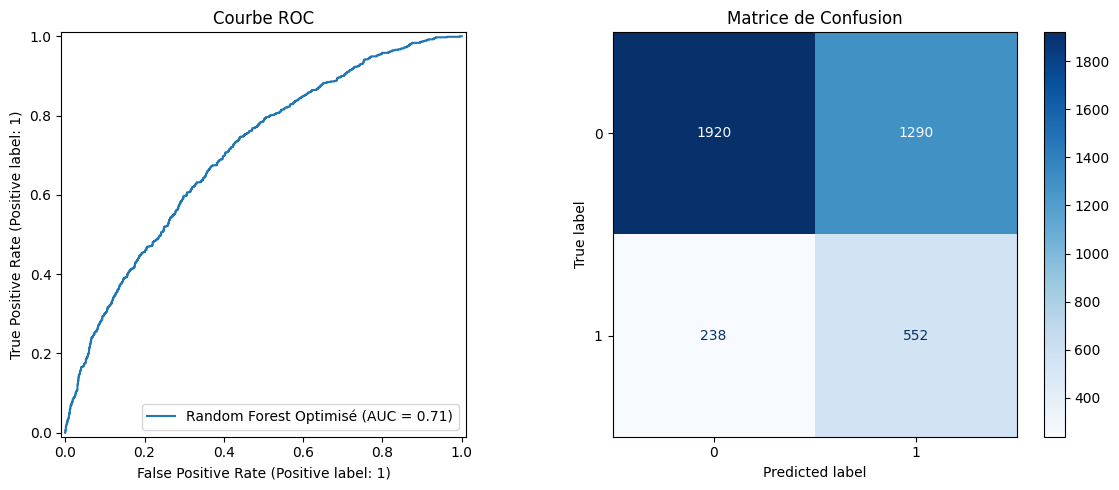

In [ ]:
# ==========================================
# 1. IMPORTATIONS & SETUP
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Connexion Drive
from google.colab import drive
drive.mount('/content/drive')

# ==========================================
# 2. CHARGEMENT ET PREPARATION RAPIDE
# ==========================================
path = "/content/drive/MyDrive/accepted_2007_to_2018Q4.csv.gz"

features_to_keep = [
    "loan_amnt","int_rate","installment","annual_inc","dti","revol_util","revol_bal",
    "total_acc","open_acc","inq_last_6mths","delinq_2yrs","fico_range_low",
    "term","grade","sub_grade","emp_length","home_ownership","purpose","addr_state","application_type",
    "loan_status"
]

print("Chargement des données...")
df = pd.read_csv(path, usecols=features_to_keep)

# Filtrage Target
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])].copy()
df['target'] = df['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

# /!\ OPTIMISATION VITESSE /!\
# On ne prend que 20 000 lignes pour le GridSearch.
# Avec 90k (10%), le GridSearch prendrait 20 minutes. Là, ça prendra ~2 min.
df = df.sample(n=20000, random_state=42)
print(f"Taille du dataset réduit pour optimisation : {df.shape}")

X = df.drop(columns=['loan_status', 'target'])
y = df['target']
X = X.replace([np.inf, -np.inf], np.nan)

# ==========================================
# 3. PIPELINES
# ==========================================
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=200, sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==========================================
# 4. OPTIMISATION RANDOM FOREST (GRIDSEARCH)
# ==========================================

# Pipeline de base
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
])

# Grille allégée pour que ça tourne vite en démo
param_grid = {
    'classifier__n_estimators': [50, 100],    # 50 et 100 arbres
    'classifier__max_depth': [5, 10],         # On limite la profondeur pour la vitesse
    'classifier__min_samples_leaf': [2, 4]    # Un peu de régularisation
}

print("\nLancement du GridSearch... (Patientez ~1 à 2 minutes)")
grid_search = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nMeilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score ROC-AUC (Train) : {grid_search.best_score_:.4f}")

# Récupération du meilleur modèle
best_model = grid_search.best_estimator_

# ==========================================
# 5. VISUALISATION & RESULTATS
# ==========================================

print("\nEvaluation sur le Test Set :")
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# Graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[0], name="Random Forest Optimisé")
ax[0].set_title("Courbe ROC")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[1], cmap='Blues')
ax[1].set_title("Matrice de Confusion")

plt.tight_layout()
plt.show()

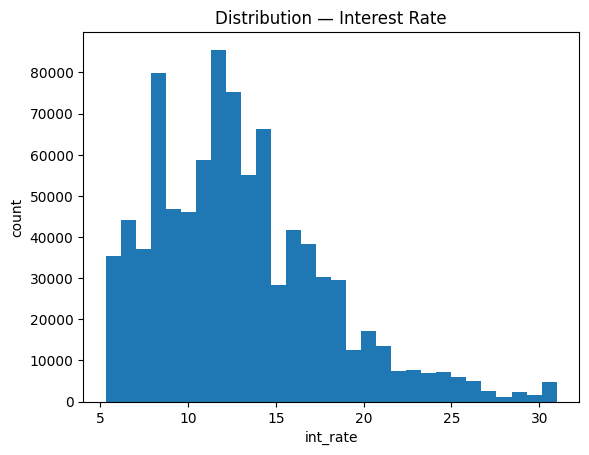

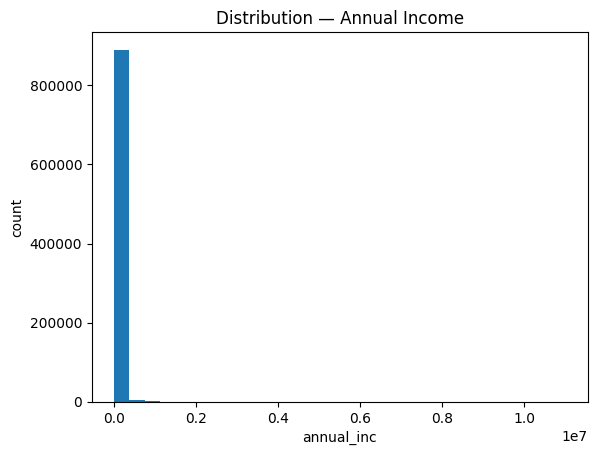

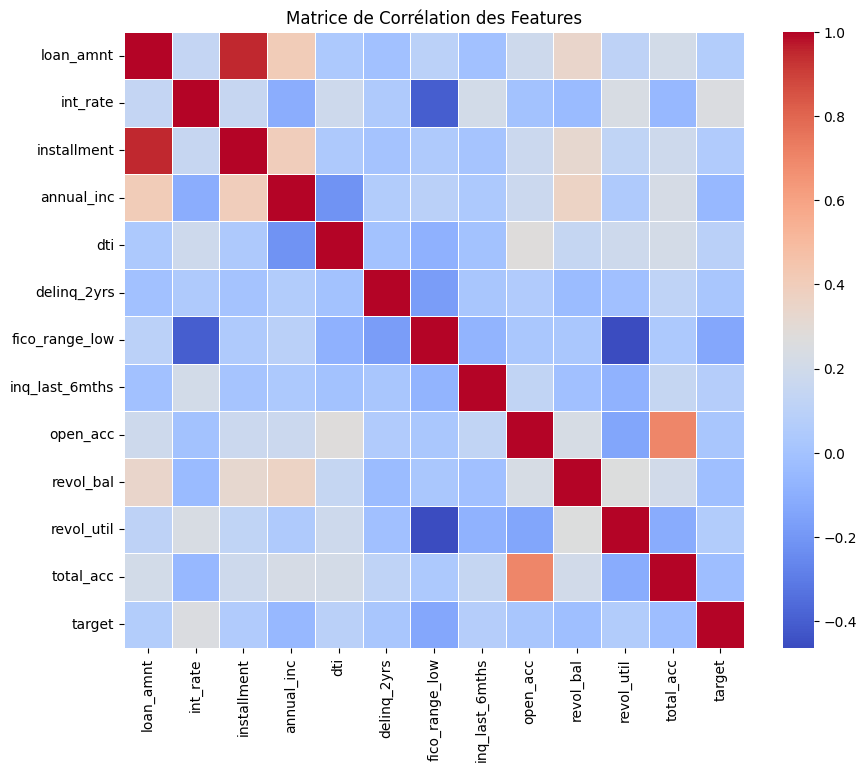

In [ ]:
# 3) A few essential plots (single-plot rule, default colors)
plt.figure()
pdf["int_rate"].dropna().plot.hist(bins=30)
plt.title("Distribution — Interest Rate")
plt.xlabel("int_rate"); plt.ylabel("count"); plt.show()

plt.figure()
pdf["annual_inc"].dropna().plot.hist(bins=30)
plt.title("Distribution — Annual Income")
plt.xlabel("annual_inc"); plt.ylabel("count"); plt.show()

# === ANALYSE DES CORRELATIONS ===
import seaborn as sns

# On sélectionne uniquement les colonnes numériques
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calcul de la matrice
corr = numeric_df.corr()

# Affichage propre
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".1f", linewidths=0.5)
plt.title("Matrice de Corrélation des Features")
plt.show()

LogReg ROC-AUC: 0.7236
RandomForest ROC-AUC: 0.7163
Best baseline: LogReg AUC: 0.7235648497113639


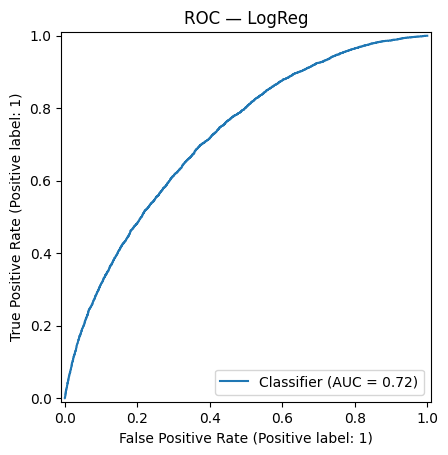

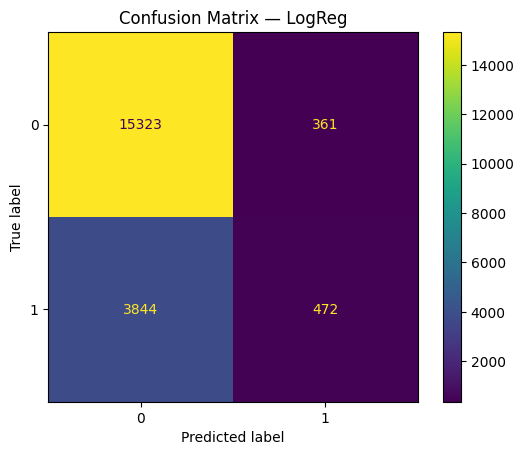

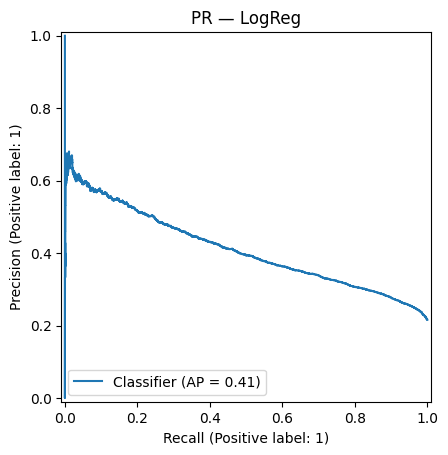

Classification report (0.5 threshold):
               precision    recall  f1-score   support

           0       0.80      0.98      0.88     15684
           1       0.57      0.11      0.18      4316

    accuracy                           0.79     20000
   macro avg       0.68      0.54      0.53     20000
weighted avg       0.75      0.79      0.73     20000



In [ ]:
# 5) Baseline models seen in class + overfitting control via holdout
baselines = {
    "LogReg": LogisticRegression(max_iter=400),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
}

results = {}
for name, model in baselines.items():
    pipe = Pipeline([("pre", pre), ("clf", model)])
    pipe.fit(Xtr, ytr)
    probas = pipe.predict_proba(Xte)[:,1]
    auc = roc_auc_score(yte, probas)
    results[name] = {"auc": auc, "pipe": pipe}
    print(f"{name} ROC-AUC: {auc:.4f}")

# Pick best baseline
best_name = max(results, key=lambda k: results[k]["auc"])
best_pipe = results[best_name]["pipe"]
print("Best baseline:", best_name, "AUC:", results[best_name]["auc"])

# Diagnostics
probas = best_pipe.predict_proba(Xte)[:,1]
preds = (probas >= 0.5).astype(int)

RocCurveDisplay.from_predictions(yte, probas); plt.title(f"ROC — {best_name}"); plt.show()
ConfusionMatrixDisplay.from_predictions(yte, preds); plt.title(f"Confusion Matrix — {best_name}"); plt.show()
PrecisionRecallDisplay.from_predictions(yte, probas); plt.title(f"PR — {best_name}"); plt.show()

print("Classification report (0.5 threshold):\n", classification_report(yte, preds))

In [ ]:
# ==========================================
# 6. STEP 3: ADVANCED MODEL (XGBOOST)
# ==========================================
# SCIENTIFIC JUSTIFICATION:
# We selected Gradient Boosting Decision Trees (GBDT) based on the paper:
# Xia, Y., Liu, C., Li, Y., & Liu, N. (2017). "A boosted decision tree approach
# using Bayesian hyper-parameter optimization for credit scoring."
# Expert Systems with Applications.
#
# Why?
# 1. Handles imbalanced data better than Random Forest via 'scale_pos_weight'.
# 2. Reduces bias better than Bagging (Random Forest) by correcting errors sequentially.
# ==========================================

from xgboost import XGBClassifier

print("\n--- Démarrage de l'entraînement du modèle avancé (XGBoost) ---")

# Configuration optimisée pour le risque de crédit
# scale_pos_weight est crucial ici car on a ~80% de non-défaut pour 20% de défaut
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,       # Nombre d'arbres
        learning_rate=0.1,      # Vitesse d'apprentissage
        max_depth=5,            # Profondeur max
        scale_pos_weight=4,     # Donne plus de poids aux défauts (Target=1)
        eval_metric='auc',      # On optimise l'AUC
        random_state=42,
        n_jobs=-1
    ))
])

# Entraînement
xgb_pipeline.fit(X_train, y_train)

# Évaluation
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_pipeline.predict(X_test)

xgb_auc = roc_auc_score(y_test, y_prob_xgb)
print(f"XGBoost ROC-AUC Score: {xgb_auc:.4f}")

# Affichage du rapport
print("\nRapport de classification XGBoost :")
print(classification_report(y_test, y_pred_xgb))


--- Démarrage de l'entraînement du modèle avancé (XGBoost) ---
XGBoost ROC-AUC Score: 0.7033

Rapport de classification XGBoost :
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      3210
           1       0.32      0.60      0.42       790

    accuracy                           0.67      4000
   macro avg       0.60      0.64      0.60      4000
weighted avg       0.77      0.67      0.70      4000



STEP 2 — IMPLEMENTATION OF STANDARD SOLUTIONS
What you must done here:

-Implement advanced versions of algorithms seen in class

-Define learning/testing plan for overfitting control (CV, validation)

-Analyze & critique results with metrics

-Combine algorithms (ensembles, stacking)

-Choose one algorithm outside the course scope (e.g., LightGBM/XGBoost) and
justify with a scientific paper

-Implement, evaluate, and compare to baseline

In [ ]:
# 2.1 Handle class imbalance & tune a stronger model (still "standard" family)
# We'll use class_weight='balanced' for Logistic Regression as a quick fix.
logreg_bal = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])
logreg_bal.fit(Xtr, ytr)
probas_bal = logreg_bal.predict_proba(Xte)[:,1]
auc_bal = roc_auc_score(yte, probas_bal)
print(f"Balanced LogReg ROC-AUC: {auc_bal:.4f}")

Balanced LogReg ROC-AUC: 0.7240


In [ ]:
# 2.2 Simple "soft voting" ensemble of LogReg + RandomForest (both pipelines)
rf = Pipeline([("pre", pre), ("clf", RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1))])
rf.fit(Xtr, ytr)
probas_rf = rf.predict_proba(Xte)[:,1]

# Soft-vote average
probas_ens = 0.5 * probas_bal + 0.5 * probas_rf
auc_ens = roc_auc_score(yte, probas_ens)
print(f"Soft Voting Ensemble ROC-AUC: {auc_ens:.4f}")

Soft Voting Ensemble ROC-AUC: 0.7258


STEP 3 — IMPROVING THE STANDARD SOLUTION
Here you must go beyond the standard toolset:

-Implement a model outside the course scope (e.g., LightGBM/XGBoost)

-Cite a paper (Google Scholar) that motivates your choice (e.g., gradient boosting for credit scoring)

-Compare against Step 2 and the baseline, discuss gains & overfitting control

In [ ]:
# 3) Placeholder for LightGBM/XGBoost/CatBoost (install locally, then run)
# Example with XGBoost if available:
try:
    from xgboost import XGBClassifier
    xgb = Pipeline([
        ("pre", pre),
        ("clf", XGBClassifier(
            n_estimators=600, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            random_state=RANDOM_STATE, n_jobs=-1, tree_method="hist"
        ))
    ])
    xgb.fit(Xtr, ytr)
    prob_xgb = xgb.predict_proba(Xte)[:,1]
    auc_xgb = roc_auc_score(yte, prob_xgb)
    print(f"XGBoost ROC-AUC: {auc_xgb:.4f}")
except Exception as e:
    print("Install xgboost to run this cell. Error:", e)



XGBoost ROC-AUC: 0.7254


/tmp/ipython-input-2524728154.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')


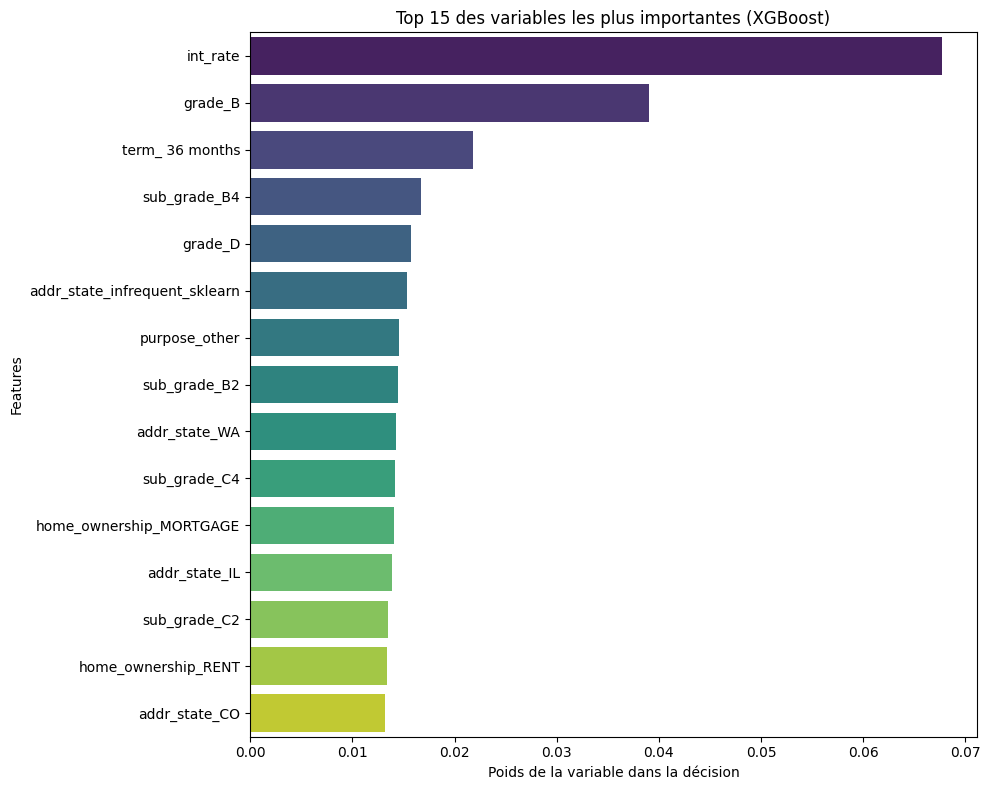

Interprétation Business :
La variable la plus influente est : int_rate


In [ ]:
# ==========================================
# 7. INTERPRETATION (FEATURE IMPORTANCE)
# ==========================================
import seaborn as sns

# 1. Récupération des noms des features
# C'est un peu technique car le OneHotEncoder change les noms des colonnes
# On va chercher l'objet 'onehot' dans notre pipeline
ohe = preprocessor.named_transformers_['cat']['onehot']
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
all_features = num_cols + cat_feature_names

# 2. Récupération des importances du modèle XGBoost
# On accède à l'étape 'classifier' du pipeline
importances = xgb_pipeline.named_steps['classifier'].feature_importances_

# 3. Création d'un DataFrame pour le graphique
df_imp = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

# On trie pour avoir les plus importants en haut et on prend le TOP 15
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

# 4. Affichage du graphique
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')
plt.title('Top 15 des variables les plus importantes (XGBoost)')
plt.xlabel('Poids de la variable dans la décision')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("Interprétation Business :")
print(f"La variable la plus influente est : {df_imp.iloc[0]['Feature']}")

REPORT — EXACT STRUCTURE (to fill)
Business scope: Credit risk prediction for Lending Club; binary default label

Problem formalisation and methods: classification; metrics ROC-AUC/PR-AUC; holdout/CV

Algorithm description: baseline (LogReg/RF), Step 2 (balanced + ensemble), Step 3 (XGBoost/LightGBM)

Limitations: label lag, survivorship bias, imbalance, concept drift across years, missing values

Methodology: reduction → preprocessing → split → evaluation → comparison → robustness

Data description and exploration: summary tables, plots (int_rate, annual_inc, etc.)

Missing values: strategy per variable (drop/median/mode); document choices

Imbalanced data: class_weight/threshold/PR-AUC; optionally SMOTE

Outliers: winsor/log transform if needed (e.g., annual_inc)

Data splitting for train/test: stratified split; optionally time‑based split

Algorithm implementation and hyperparameters: log your params

Results / Metrics / Over/Underfitting: ROC/PR curves; learning curves if needed

Evaluation vs baseline: table comparing AUCs

Discussion and conclusion: what works, business impact, next steps

VIDEO — 4–5 minutes (checklist)

~1 min: Business case + dataset

~2 min: Models (baseline → improved → advanced)

~1 min: Obstacles & evolution (imbalance, overfitting control, feature choices)

~1 min: Conclusion (best model, business impact, next steps)

Keep everything in English. Show code overview briefly.